Foreign holdings (ratio) seem to have a high correlation with stock prices
- This should be natural if foreign investors play a key role in controlling prices
- However, it appears that foreign investors may act more quickly in response to steep price declines (just a hypothesis)

Implications
- If a certain stock has incresing or consistently high foreign holdings while prices are declining,  it might be a good startegy to consider for investment
- If foreign investers are rapidly selling, it could serve as a sell signal for us as well

Insights
- This analysis could yield interesting and meaningful insights: which companies' stock prices are highly correlated with foreign investors 
    - However, several additional aspects need to be considered: trading volume, financial stability, the absolute amount of foreign holdings, as well as the volatility of foreign holdings
- Certain stocks exhibit high correlations with D, W, M (last 30 data points) both individually and collectively 
    - For these companies, we should closely monitor foreign holdigs going forward, and develop appropriate strategies accordingly (**strategy to be developed**)
- On the other hand, certain stocks display high correlations with repsect to W, M, but show little to no correlations (or negative correlation) with respect to D 
    - For these companies, opportunities maybe already at present (**strategy to be developed**)

In [1]:
import FinanceDataReader as fdr
import pandas as pd
import OpenDartReader 
import json

In [69]:
from mojito import * 
from pprint import pprint

with open('../../config/config.json', 'r') as json_file:
    config = json.load(json_file)
    key = config['key']
    secret = config['secret']
    acc_no = config['acc_no']
    # key_mock = config['key_mock']
    # secret_mock = config['secret_mock']
    # acc_no_mock = config['acc_no_mock']

broker = KoreaInvestment(api_key=key, api_secret=secret, acc_no=acc_no, mock=False)
# broker = KoreaInvestment(api_key=key_mock, api_secret=secret_mock, acc_no=acc_no_mock, mock=True)

def fetch_foreign_holdings(code, period): 
    # period: D, W, M
    base_url = "https://openapi.koreainvestment.com:9443"
    path = "/uapi/domestic-stock/v1/quotations/inquire-daily-price"
    url = f"{base_url}/{path}"
    headers = {
        "content-type": "application/json; charset=utf-8",
        "authorization": broker.access_token,
        "appKey": broker.api_key,
        "appSecret": broker.api_secret,
        "tr_id": "FHKST01010400",
        "tr_cont": "",
    }

    params = {
        "fid_cond_mrkt_div_code": "J",
        "fid_input_iscd": code,
        "FID_PERIOD_DIV_CODE":period, 
        "FID_ORG_ADJ_PRC":"0000000000" # modified stock prices
    }

    res = requests.get(url, headers=headers, params=params)
    if res.json()['rt_cd'] == '0' and len(res.json()['output']) > 0:
        res = pd.DataFrame(res.json()['output'])
    else: 
        return None

    type_casting = {'stck_clpr':'int', 'hts_frgn_ehrt':'float'}
    res = res.astype(type_casting)
    foreign_holdings = res.set_index('stck_bsop_date')[['stck_clpr', 'hts_frgn_ehrt']].sort_index()
    corr = foreign_holdings['stck_clpr'].corr(foreign_holdings['hts_frgn_ehrt'])

    return foreign_holdings, corr

def fetch_all_foreign_holdings(code): 
    fh_d, cr_d = fetch_foreign_holdings(code, 'D')
    fh_w, cr_w = fetch_foreign_holdings(code, 'W')
    fh_m, cr_m = fetch_foreign_holdings(code, 'M')

    fh_d = fh_d.reset_index().rename(columns={'stck_bsop_date':'date_d', 'stck_clpr':'price_d', 'hts_frgn_ehrt':'fh_d'})
    fh_w = fh_w.reset_index().rename(columns={'stck_bsop_date':'date_w', 'stck_clpr':'price_w', 'hts_frgn_ehrt':'fh_w'})
    fh_m = fh_m.reset_index().rename(columns={'stck_bsop_date':'date_m', 'stck_clpr':'price_m', 'hts_frgn_ehrt':'fh_m'})

    fh = pd.concat([fh_d, fh_w, fh_m], axis=1)
    return fh, [code, cr_d, cr_w, cr_m]

def fetch_corr_foreign_holdings(code): 
    fh_d, cr_d = fetch_foreign_holdings(code, 'D')
    fh_w, cr_w = fetch_foreign_holdings(code, 'W')
    fh_m, cr_m = fetch_foreign_holdings(code, 'M')

    return [code, cr_d, cr_w, cr_m]

In [ ]:
# prepration of target companies set
import time

MARCAP_THRESHOLD = 5000*10**8 
IPO_YEAR_THRESHOLD = 3 

df_krx = pd.read_feather('df_krx.feather')
df_krx = df_krx.loc[df_krx['Marcap'] >= MARCAP_THRESHOLD]
df_krx = df_krx.loc[pd.Timestamp.today()- df_krx['ListingDate'] > pd.Timedelta(days = IPO_YEAR_THRESHOLD*(365+1))]
print(len(df_krx))

corr = []
i = 0
for code in df_krx.index:
    corr_ = fetch_corr_foreign_holdings(code)
    print(i)
    i += 1
    time.sleep(0.5)
    corr_.append(df_krx.loc[code, 'Name'])
    corr.append(corr_)
    print(corr_)

corr = pd.DataFrame(corr, columns=['code', 'd', 'w', 'm', 'name'])

corr['average'] = corr[['d', 'w', 'm']].mean(axis=1)
corr['std']= corr[['d', 'w', 'm']].std(axis=1)
corr.to_feather('corr.feather')

,code,d,w,m,name,average,std
0,005930,0.842968,0.799017,0.861788,삼성전자,0.834591,0.032213
5,006400,0.733643,0.877878,0.311945,삼성SDI,0.641155,0.294084
12,012330,0.748495,0.709220,0.255707,현대모비스,0.571141,0.273878
25,138040,0.958558,0.646054,0.654703,메리츠금융지주,0.753105,0.177980
27,015760,0.466253,0.681335,0.708468,한국전력,0.618685,0.132705
36,024110,0.864771,0.928675,0.416220,기업은행,0.736555,0.279252
50,005830,0.873043,0.631201,0.821019,DB손해보험,0.775087,0.127295
51,066970,0.922993,0.751639,0.900210,엘앤에프,0.858281,0.093054
53,028050,0.309895,0.666692,0.800387,삼성엔지니어링,0.592325,0.253562
63,036570,0.824903,0.936352,0.878805,엔씨소프트,0.880020,0.055734


,code,d,w,m,name,average,std
0,005930,0.842968,0.799017,0.861788,삼성전자,0.834591,0.032213
51,066970,0.922993,0.751639,0.900210,엘앤에프,0.858281,0.093054
63,036570,0.824903,0.936352,0.878805,엔씨소프트,0.880020,0.055734
68,047810,0.739689,0.878423,0.866385,한국항공우주,0.828166,0.076859
188,140410,0.703990,0.787408,0.714432,메지온,0.735277,0.045448
206,140860,0.665724,0.700043,0.777181,파크시스템스,0.714316,0.057083
259,098460,0.626434,0.706224,0.804524,고영,0.712394,0.089205
295,294870,0.841076,0.853047,0.755135,HDC현대산업개발,0.816419,0.053410
305,001680,0.787047,0.901137,0.833628,대상,0.840604,0.057364


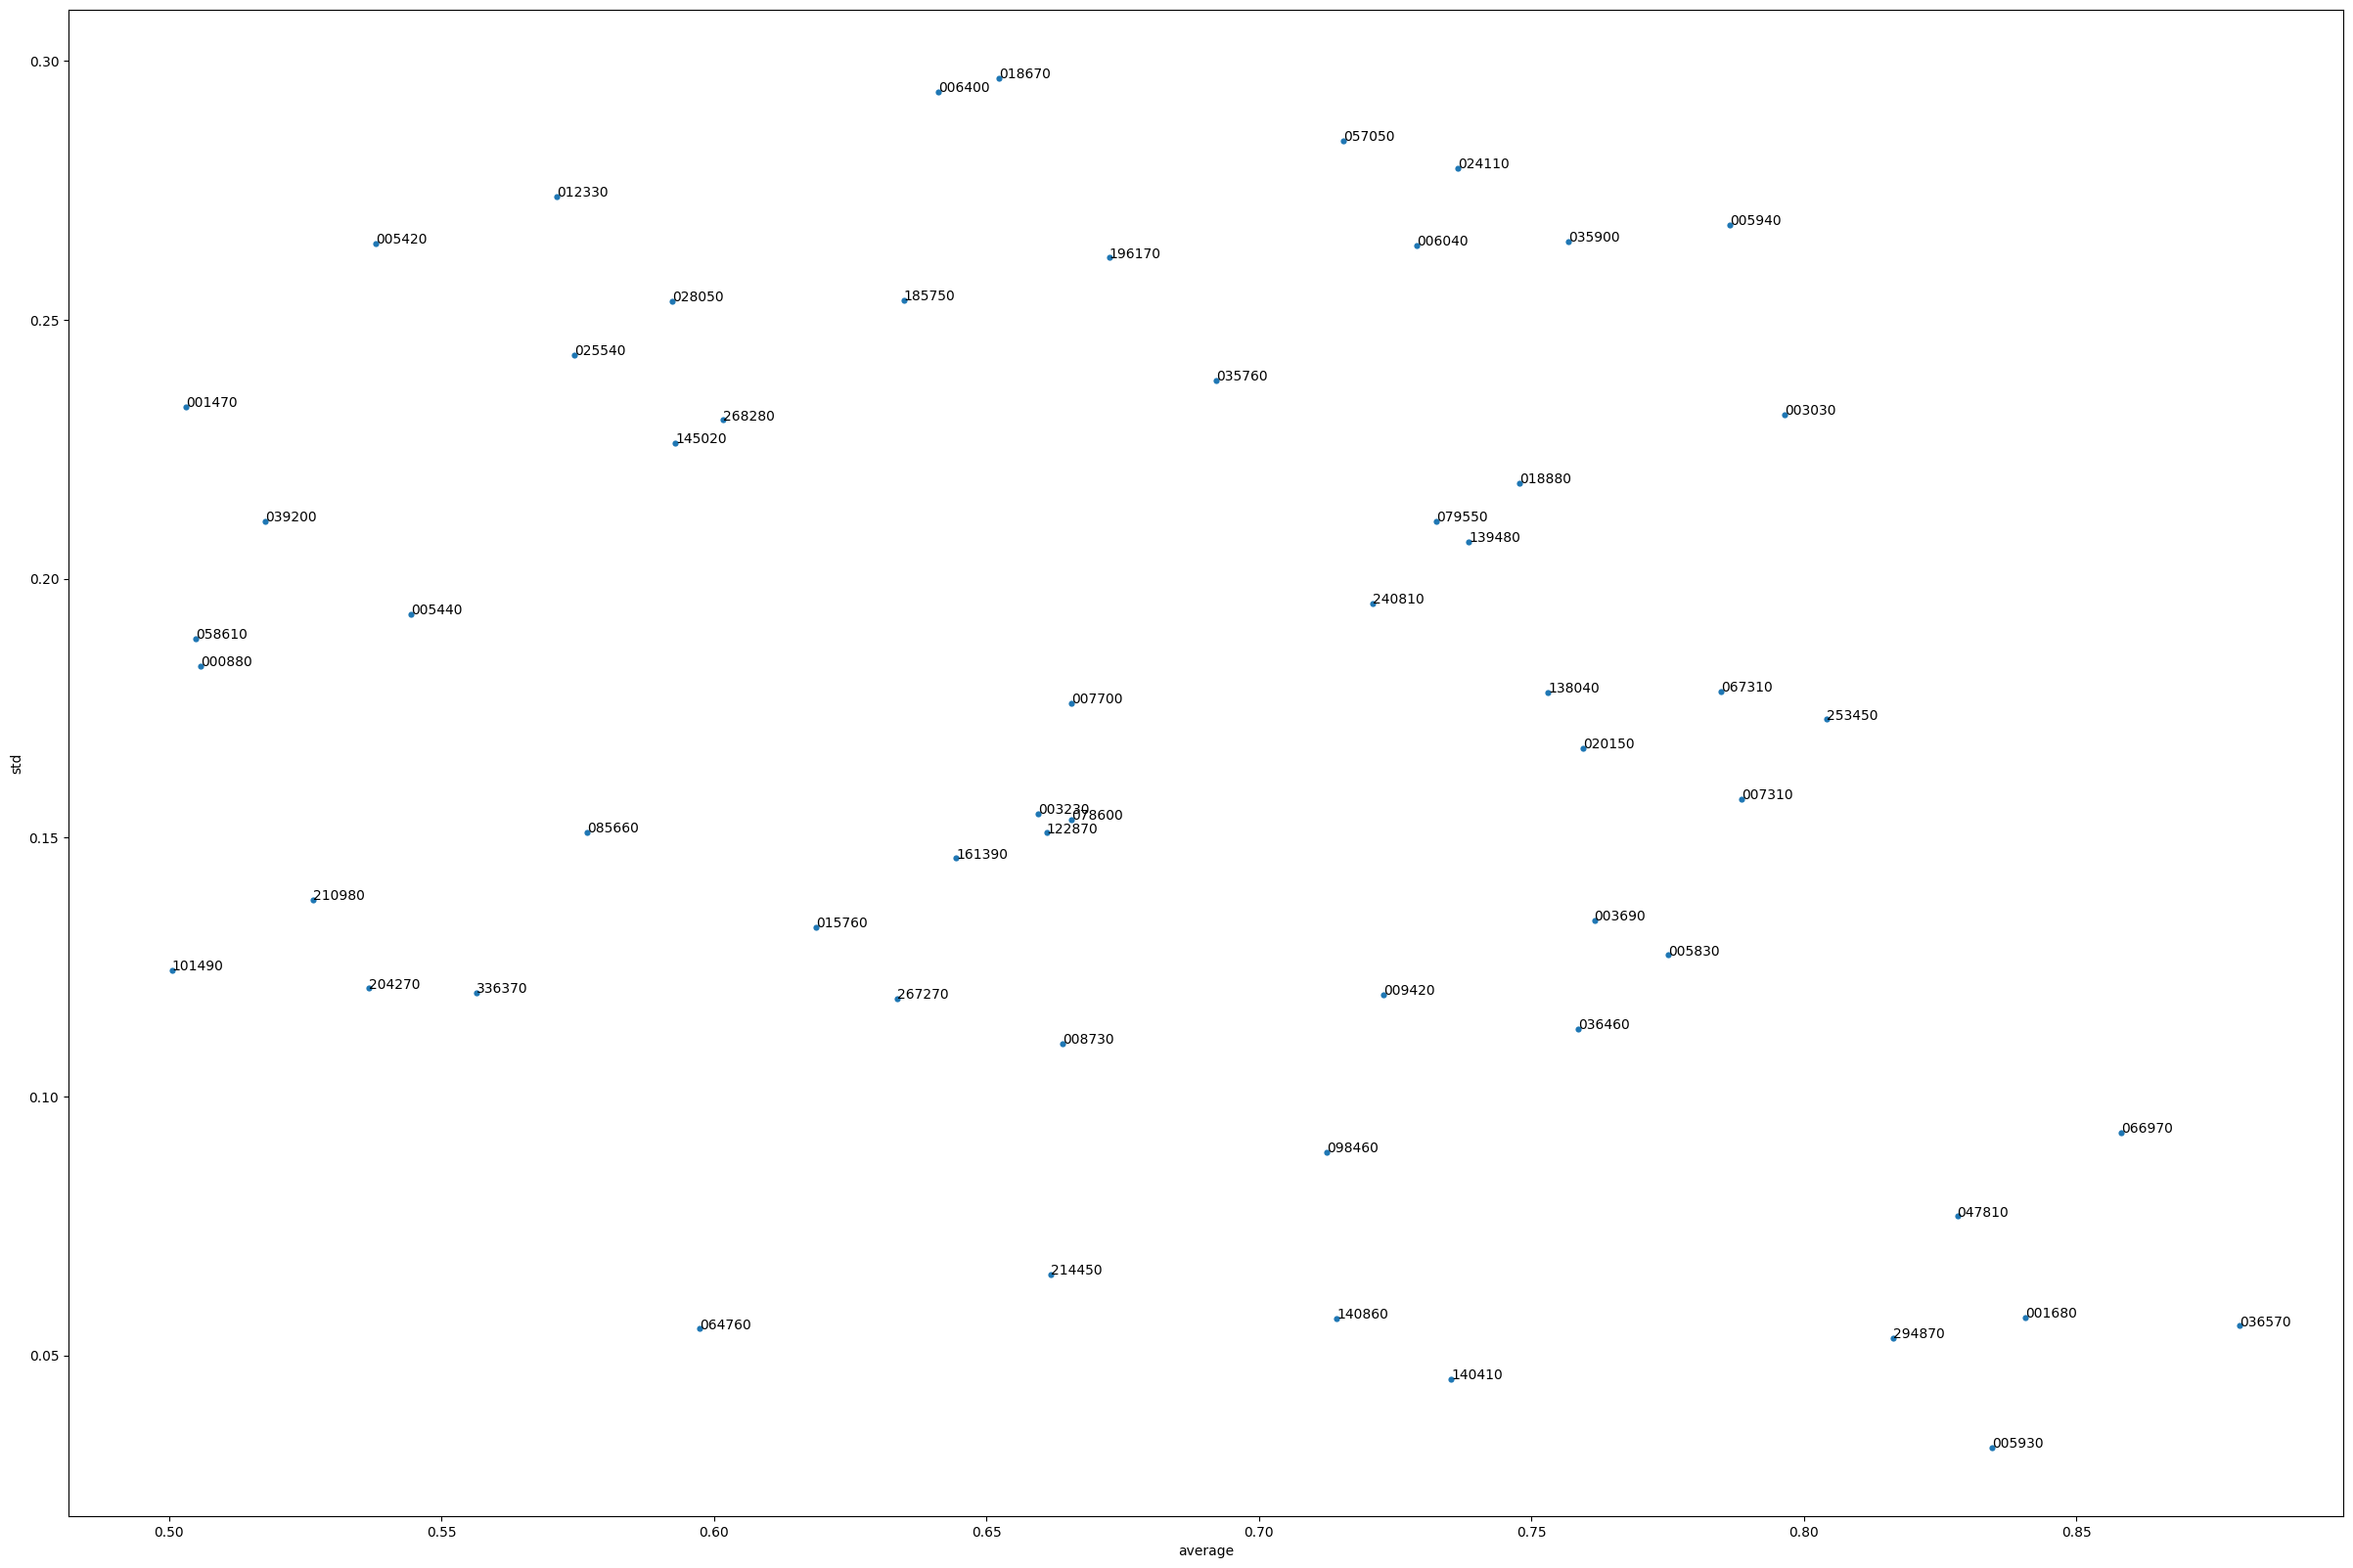

In [121]:
corr = pd.read_feather('corr.feather')
corr.dropna(inplace=True)
corr_set = corr.loc[(corr['average'] > 0.5) & (corr['std'] < 0.3)]
display(corr_set)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
corr_set.plot('average', 'std', kind='scatter', ax=ax, linewidth=0, figsize=(30,20))

for k, v in corr_set[['average', 'std']].iterrows():
    ax.annotate(corr_set.loc[k, 'code'], v)

corr_top = corr.loc[(corr['average'] > 0.7) & (corr['std'] < 0.1)]
display(corr_top)

삼성전자
엘앤에프
엔씨소프트
한국항공우주
메지온
파크시스템스
고영
HDC현대산업개발
대상


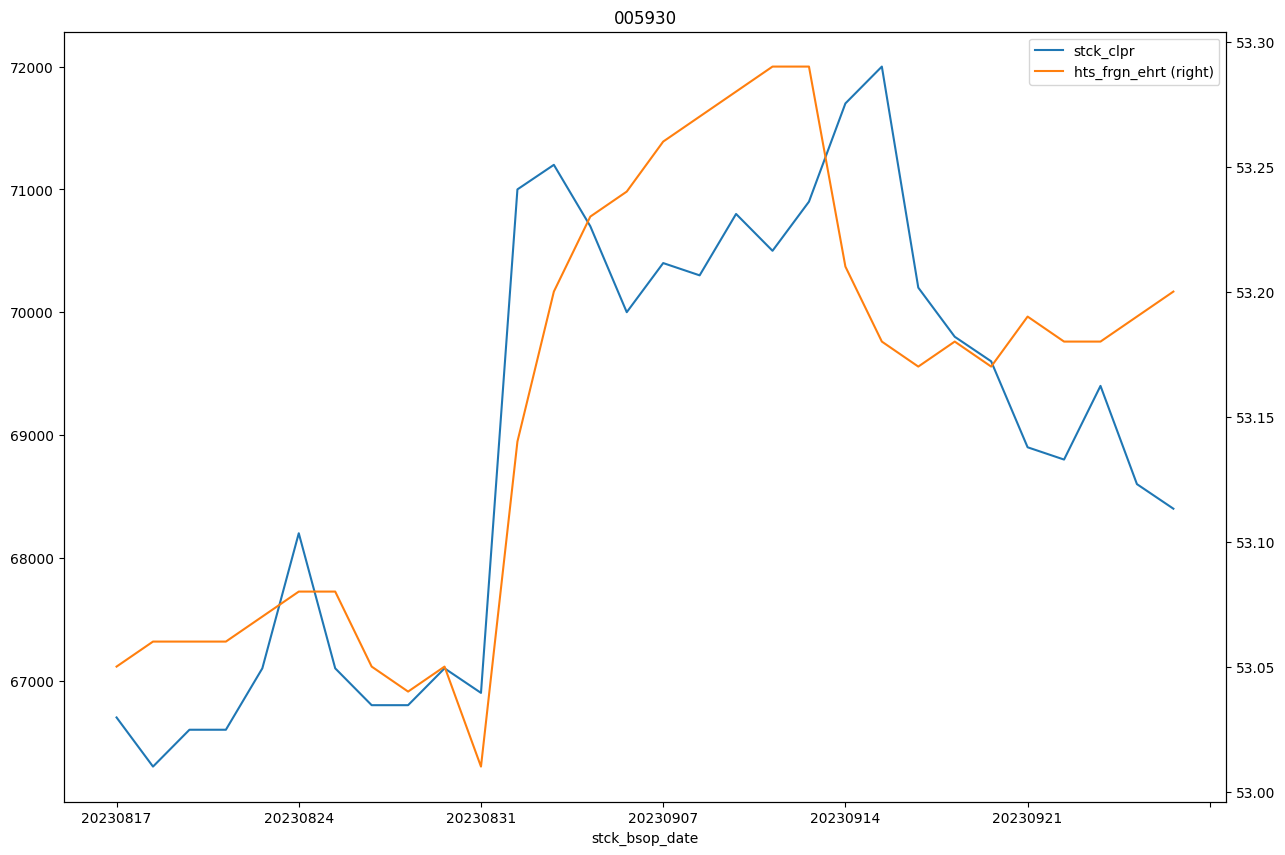

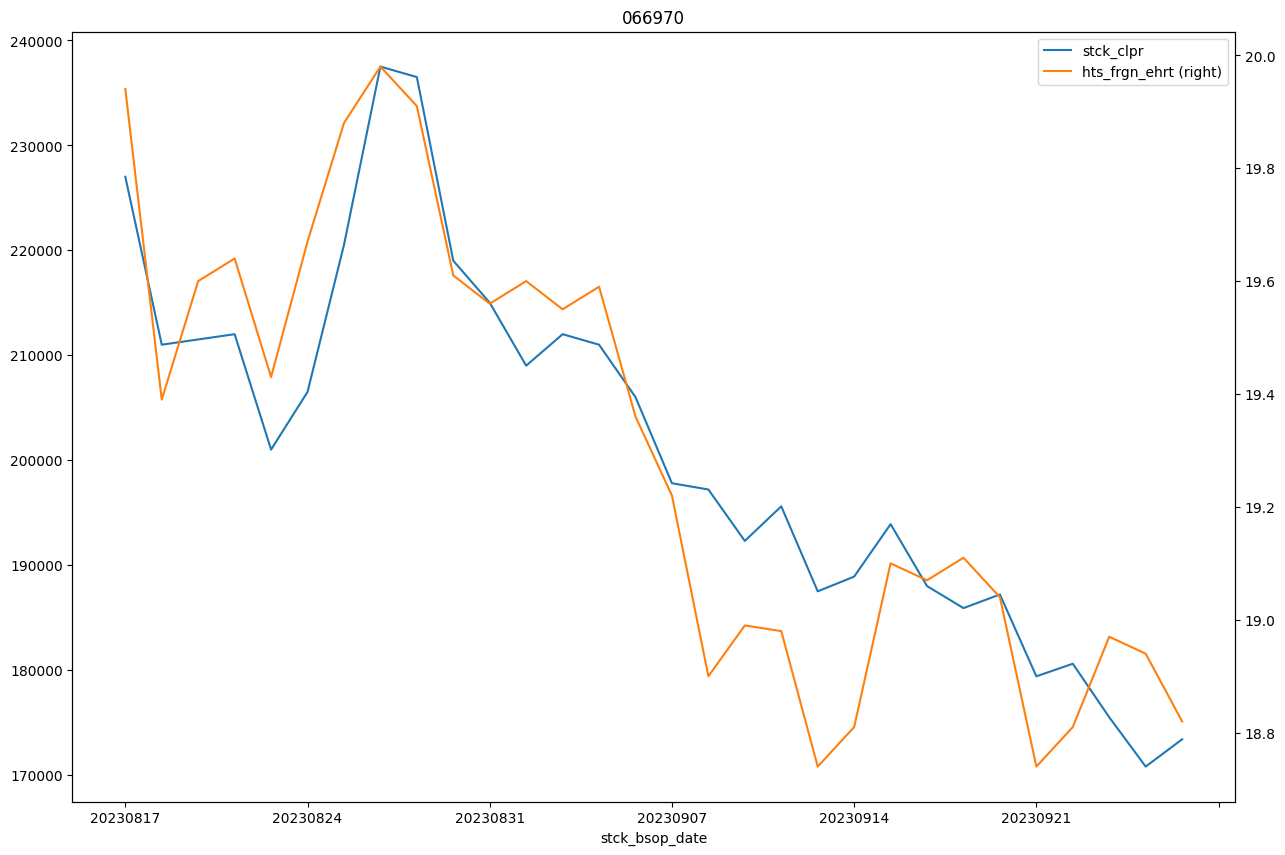

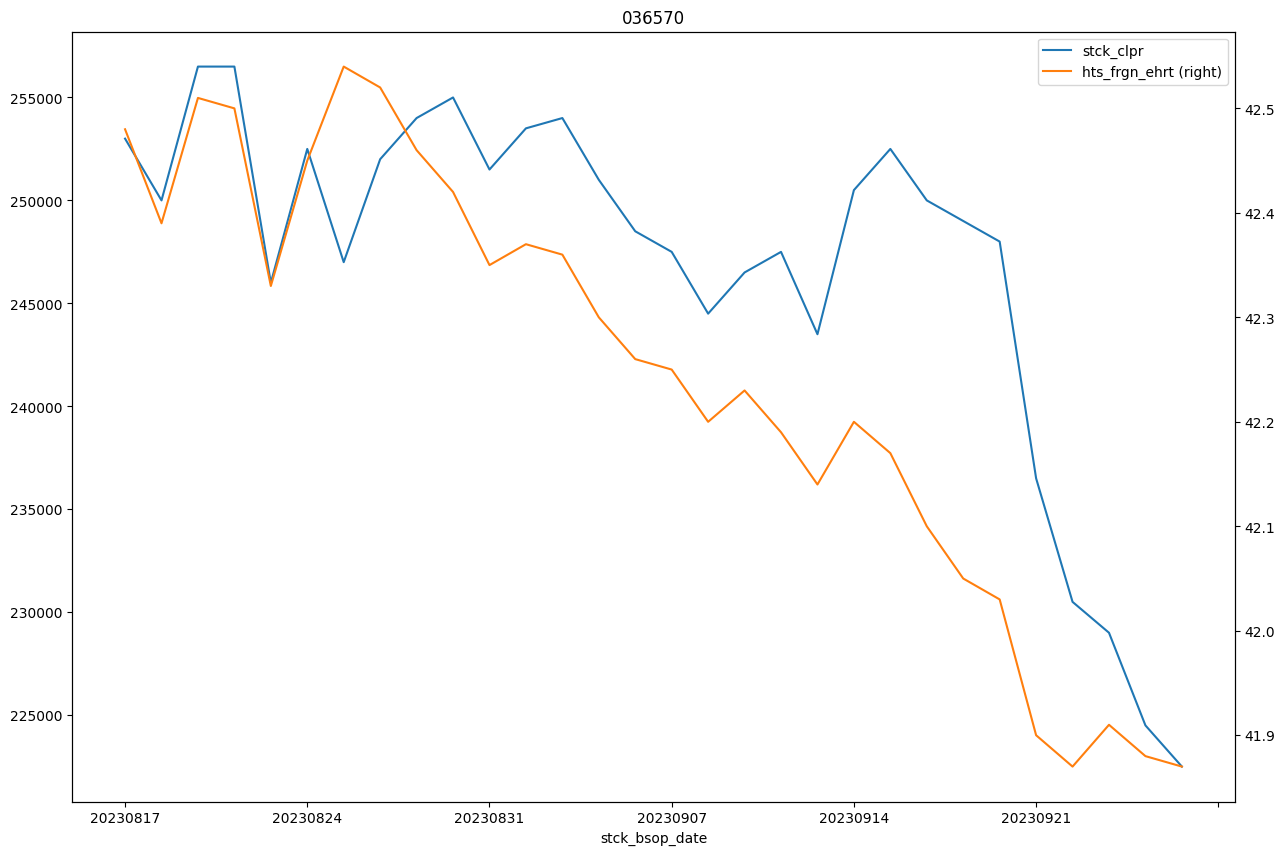

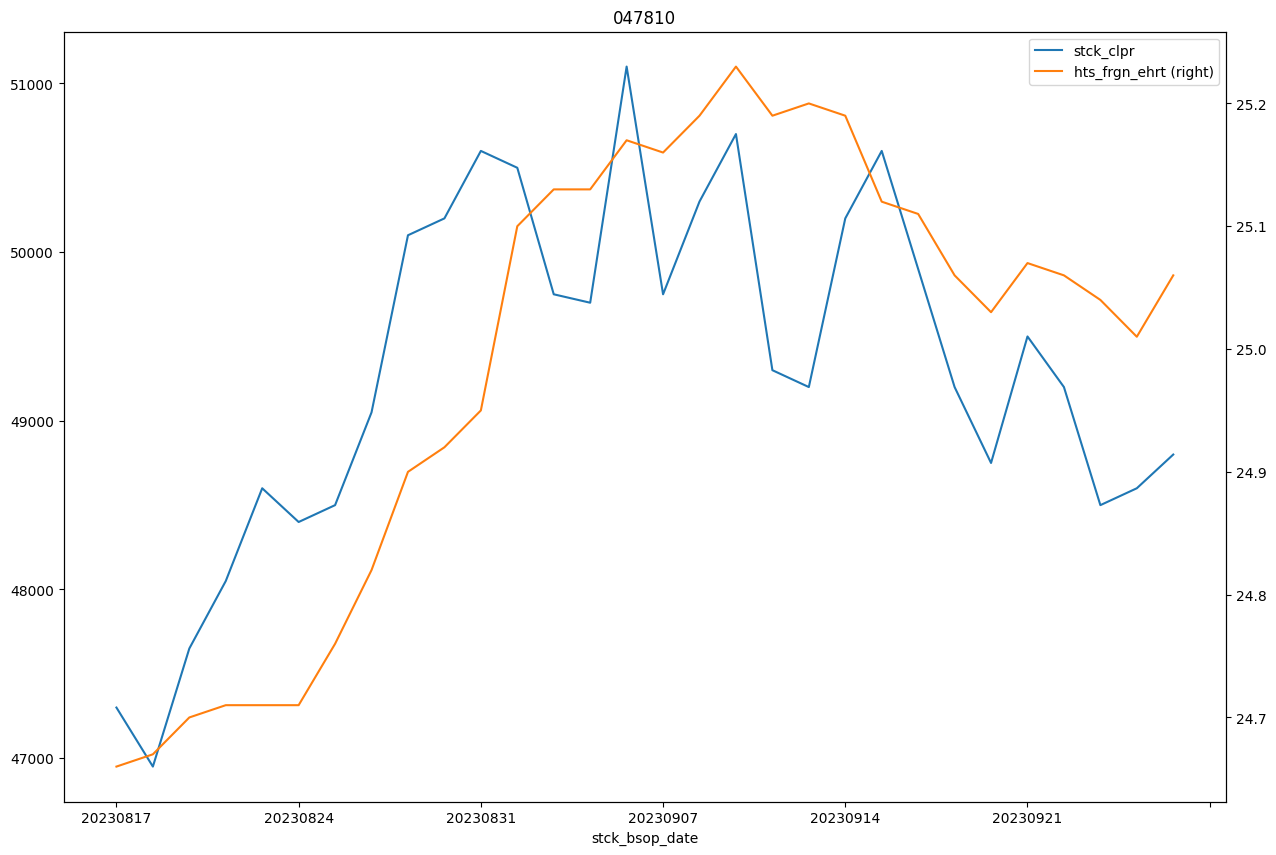

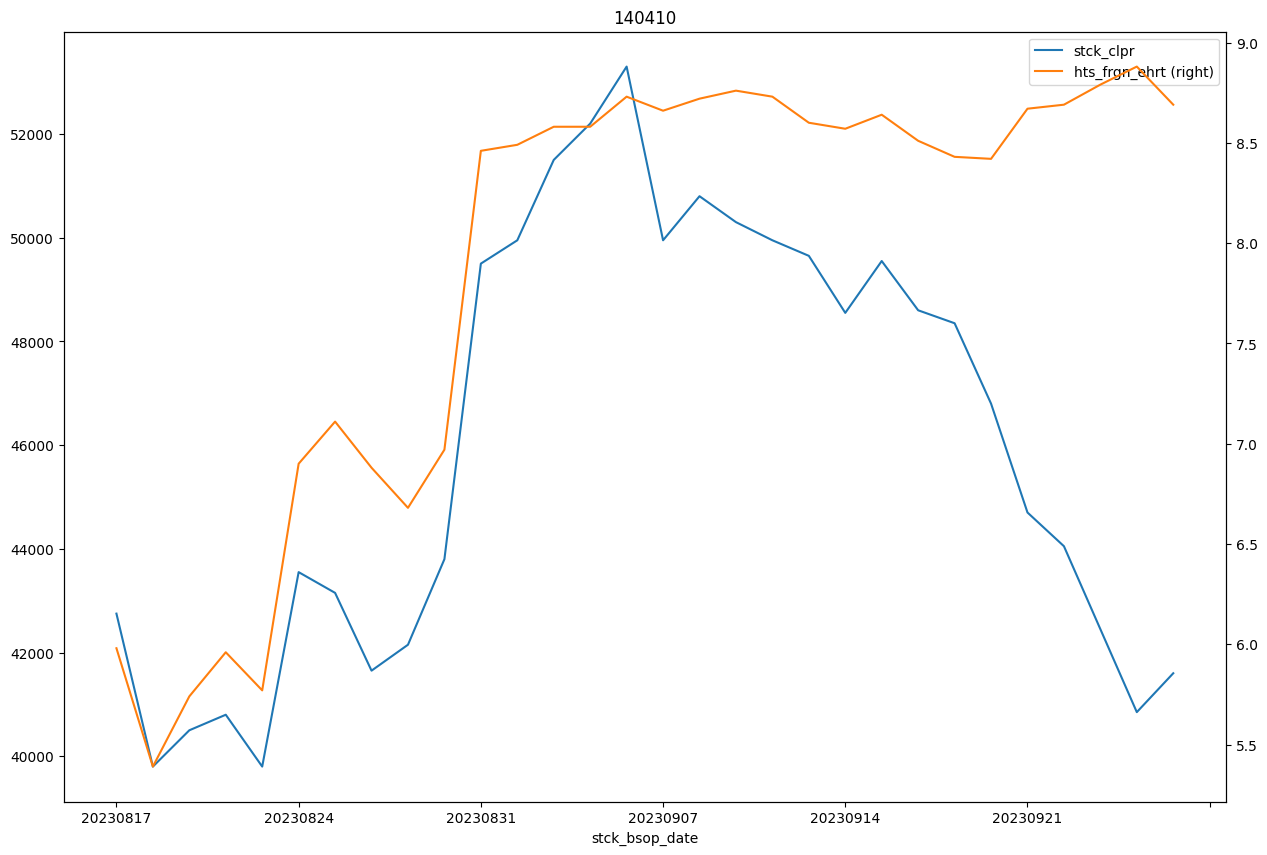

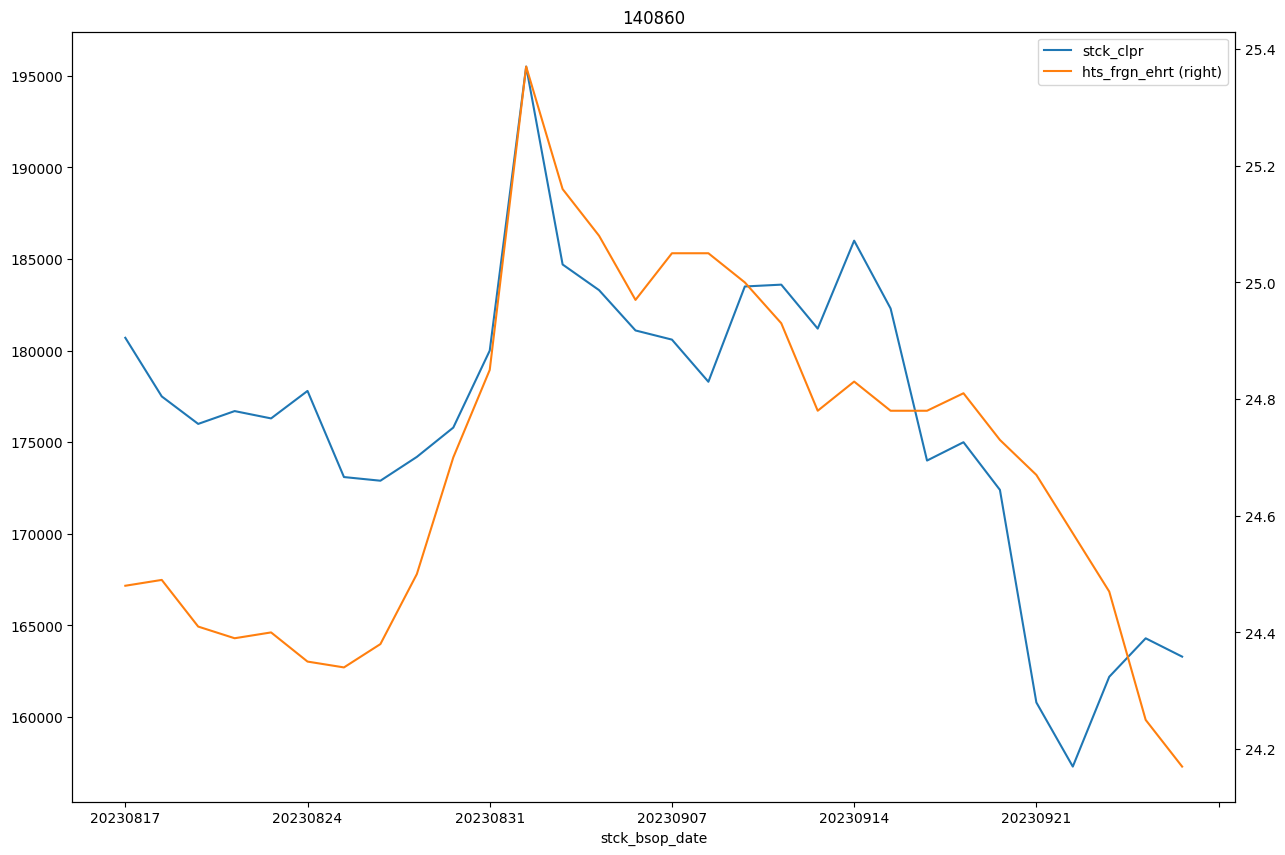

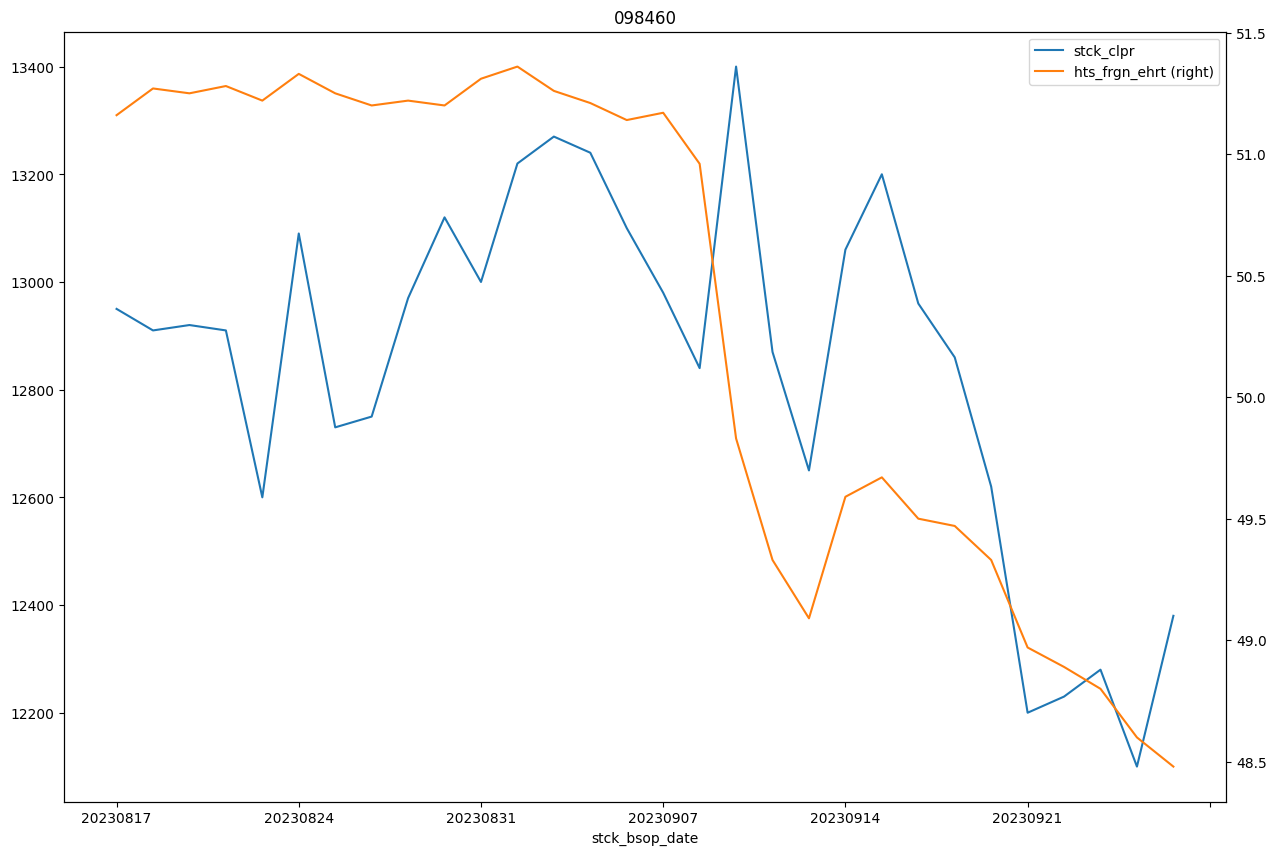

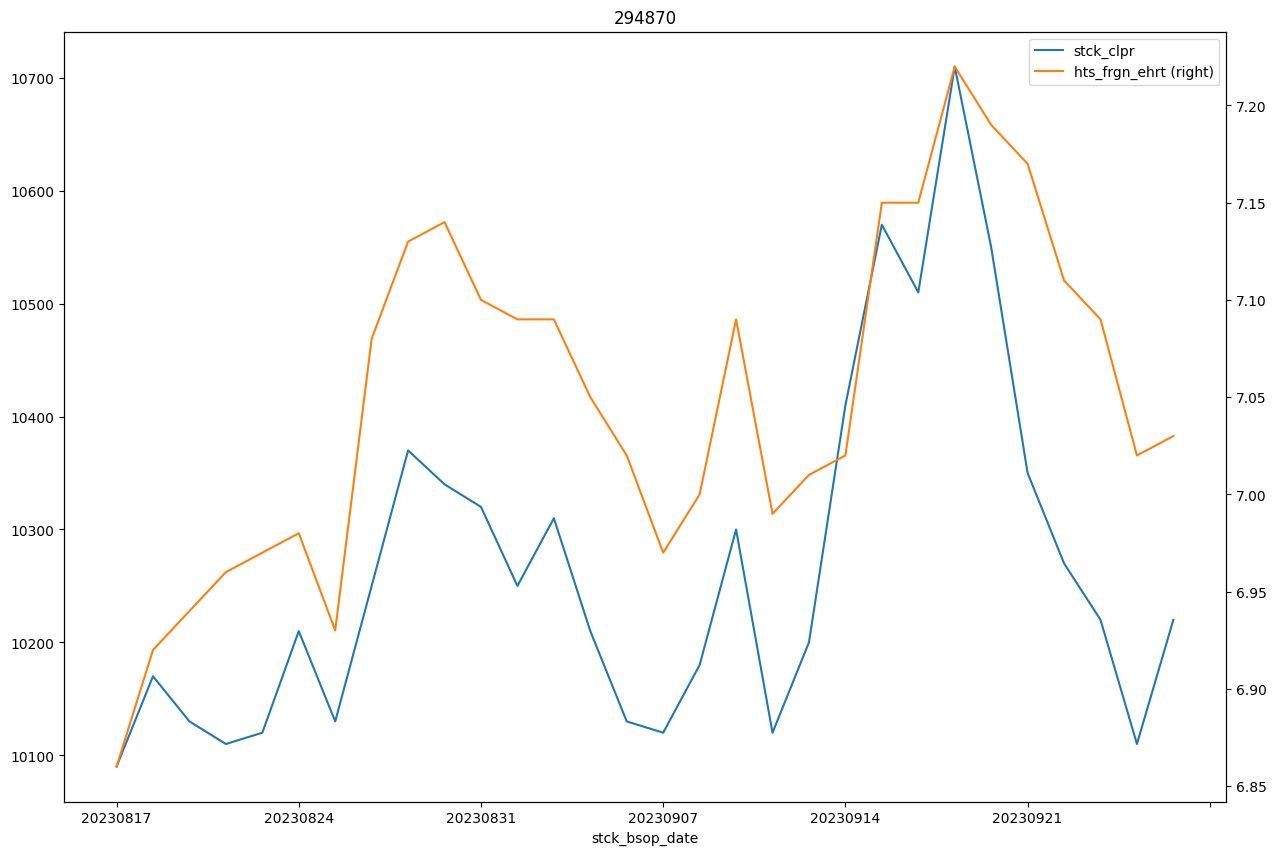

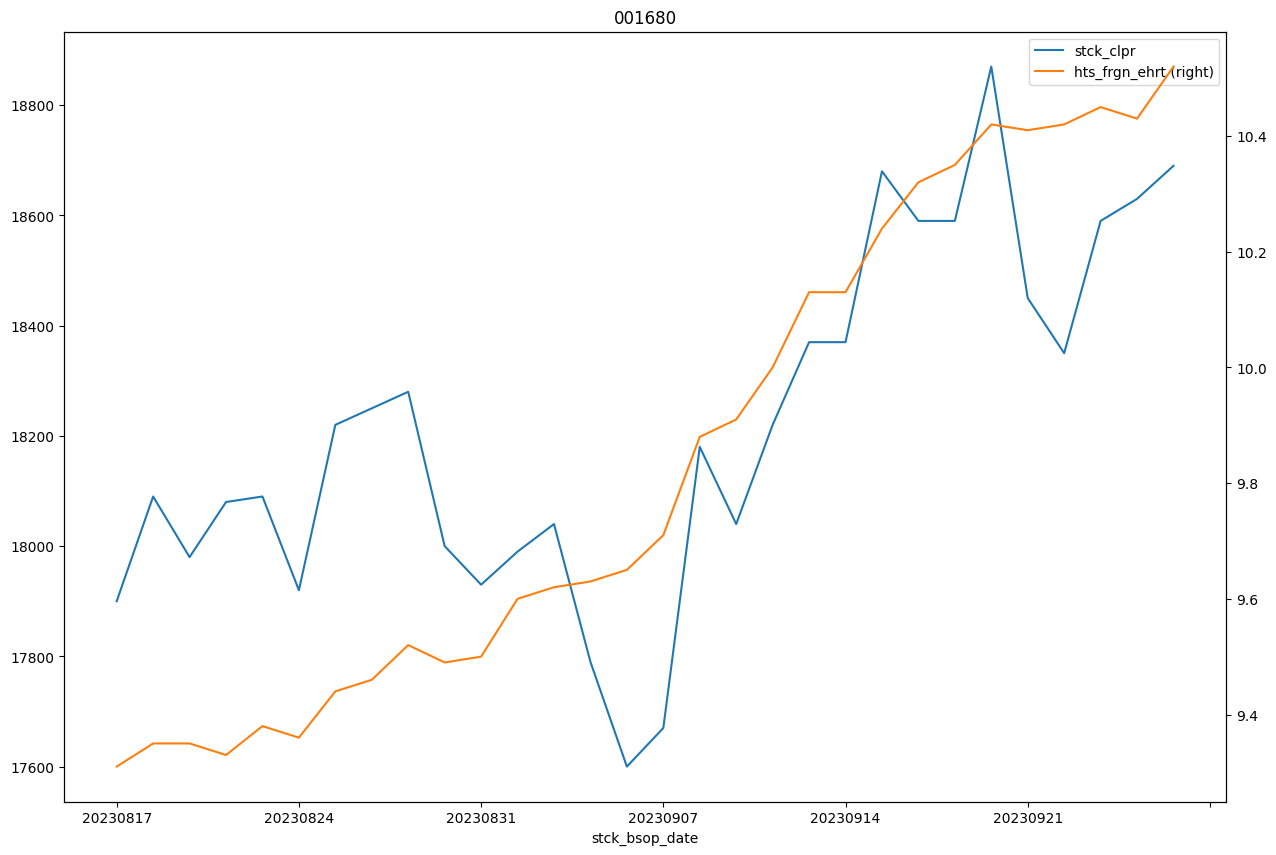

In [137]:

for code in corr_top['code']: 
    print(corr_top.loc[corr_top['code']==code, 'name'].values[0])
    fh, cr = fetch_foreign_holdings(code, 'D')
    fh.plot(figsize=(15, 10), secondary_y='hts_frgn_ehrt', title=code)

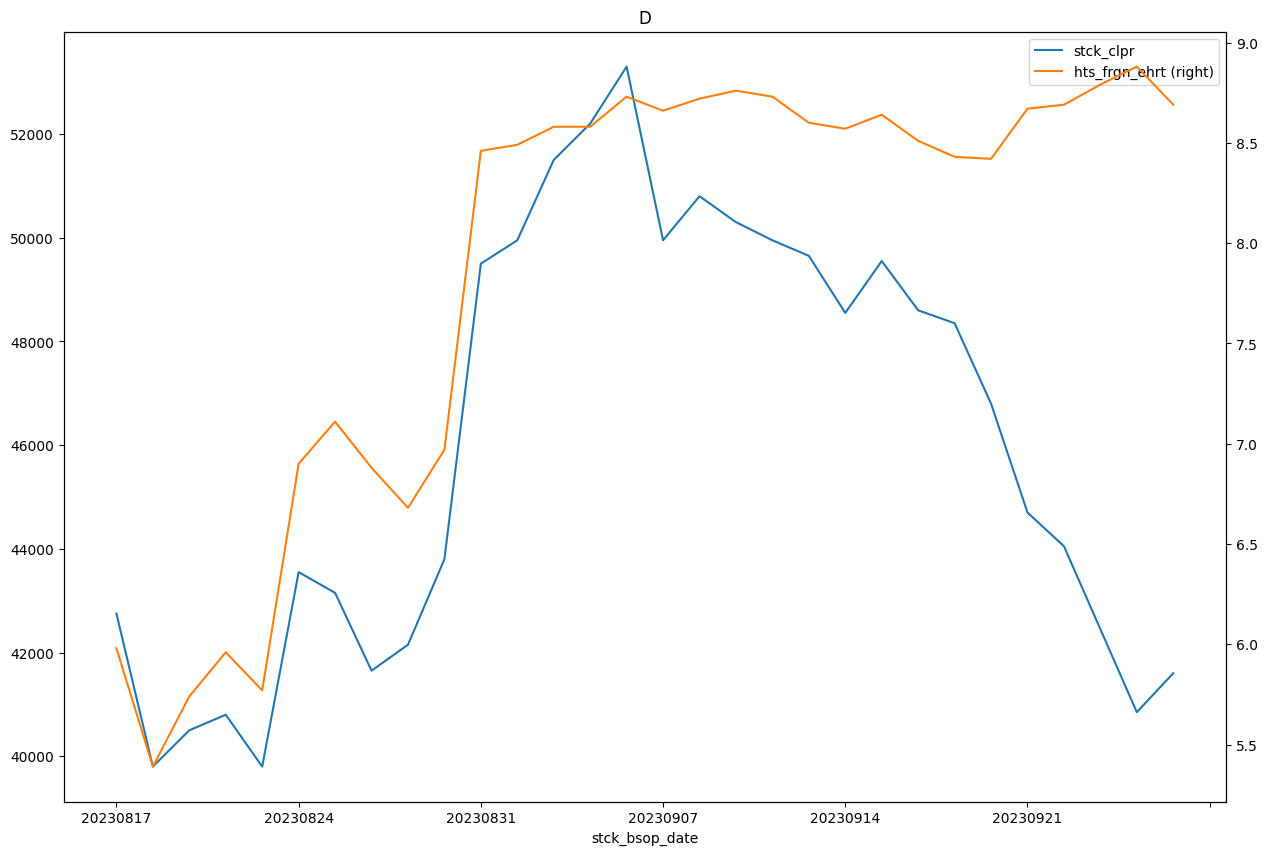

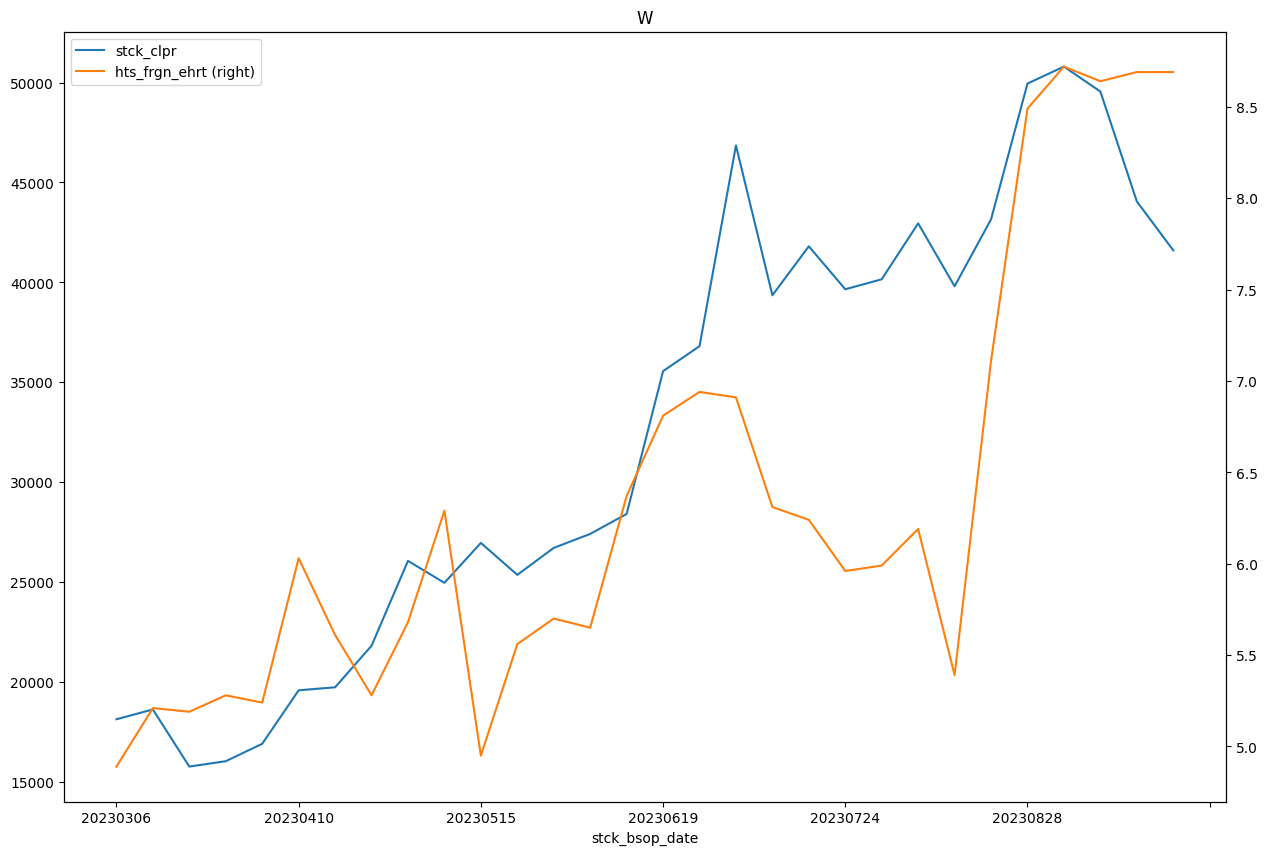

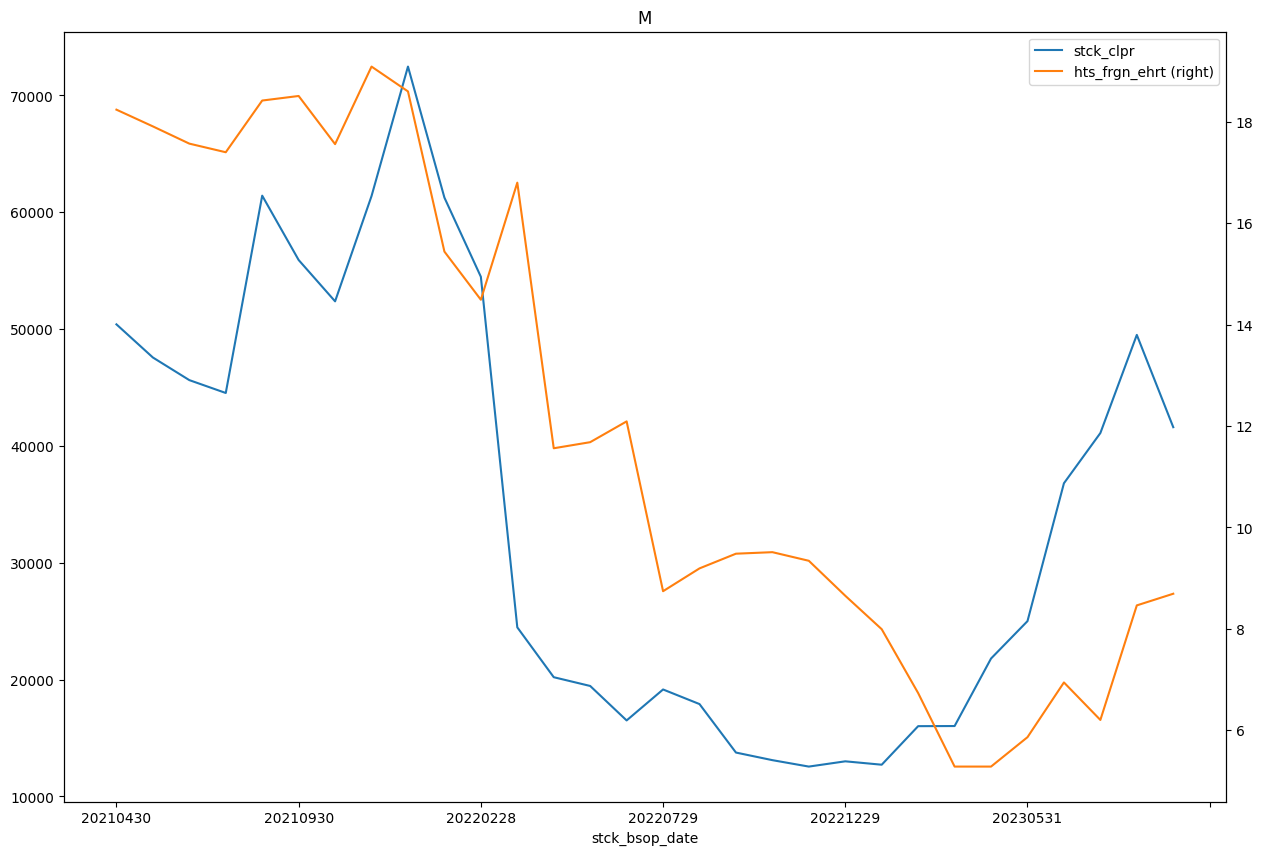

In [144]:
def plot_fholdings(code):
    fh, cr = fetch_foreign_holdings(code, 'D')
    fh.plot(figsize=(15, 10), secondary_y='hts_frgn_ehrt', title='D')
    fh, cr = fetch_foreign_holdings(code, 'W')
    fh.plot(figsize=(15, 10), secondary_y='hts_frgn_ehrt', title='W')
    fh, cr = fetch_foreign_holdings(code, 'M')
    fh.plot(figsize=(15, 10), secondary_y='hts_frgn_ehrt', title='M')
    return None

plot_fholdings('140410')

In [143]:
corr[corr[['w', 'm']].min(axis=1) > 0.7].sort_values('d')

,code,d,w,m,name,average,std
99,004370,-0.742809,0.792317,0.887070,농심,0.312193,0.914886
224,336570,-0.713554,0.890413,0.913759,원텍,0.363539,0.932863
354,083310,-0.623230,0.882445,0.786800,엘오티베큠,0.348672,0.843049
46,051900,-0.492190,0.775680,0.951680,LG생활건강,0.411723,0.787742
238,287410,-0.366064,0.809447,0.778688,제이시스메디칼,0.407357,0.669979
174,009240,-0.319152,0.834841,0.860508,한샘,0.458732,0.673790
67,042700,-0.222906,0.889562,0.892025,한미반도체,0.519561,0.642996
264,000400,-0.138329,0.769231,0.716625,롯데손해보험,0.449176,0.509473
65,307950,0.079116,0.878490,0.710689,현대오토에버,0.556098,0.421513
107,007070,0.089993,0.834385,0.816583,GS리테일,0.580320,0.424729


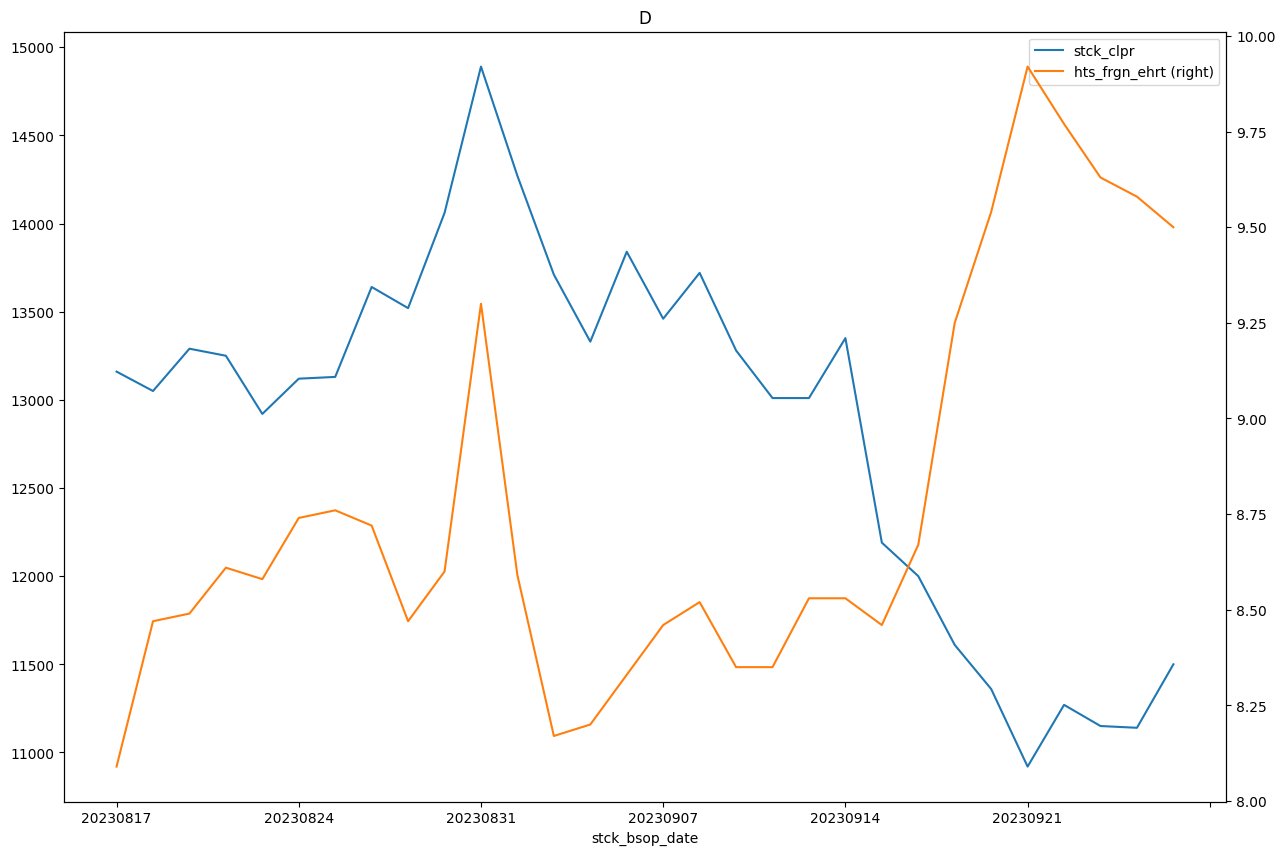

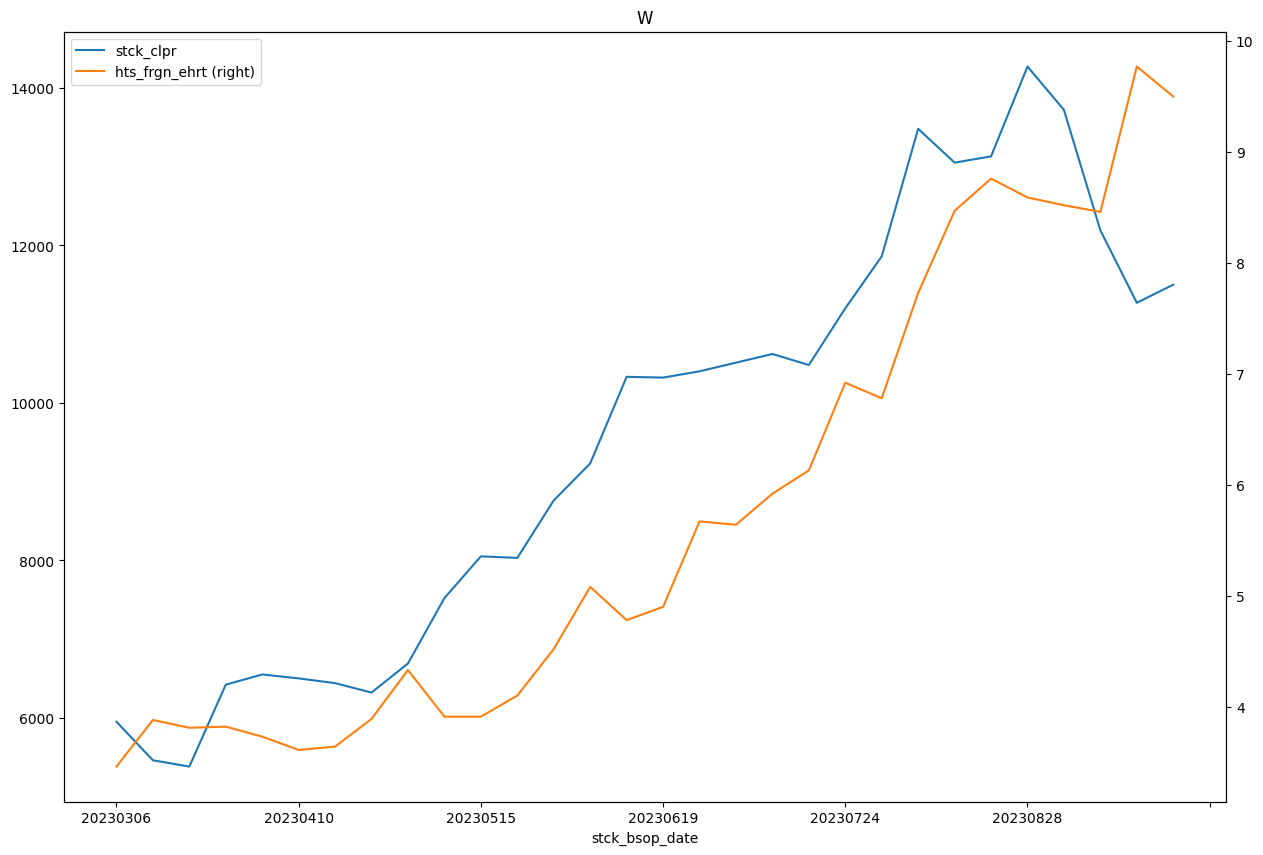

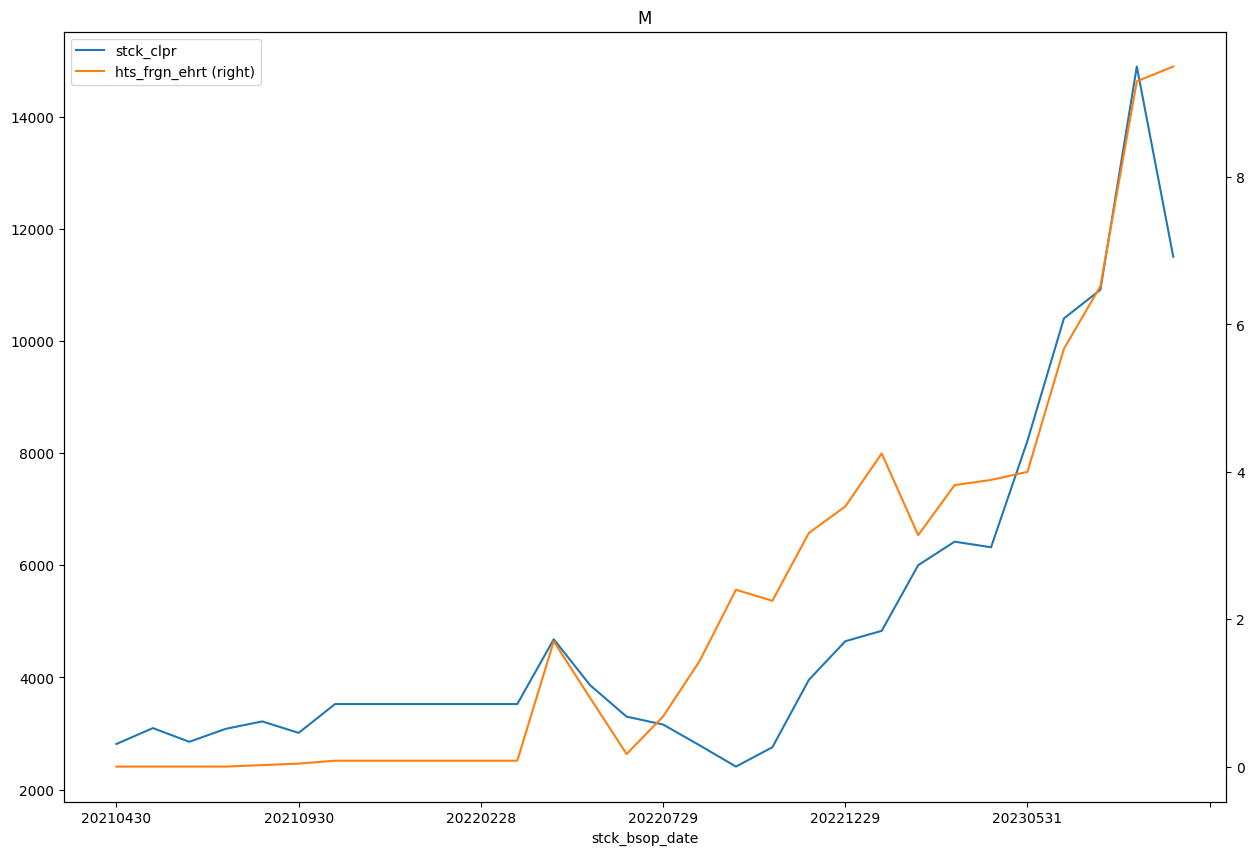

In [146]:
plot_fholdings('336570')

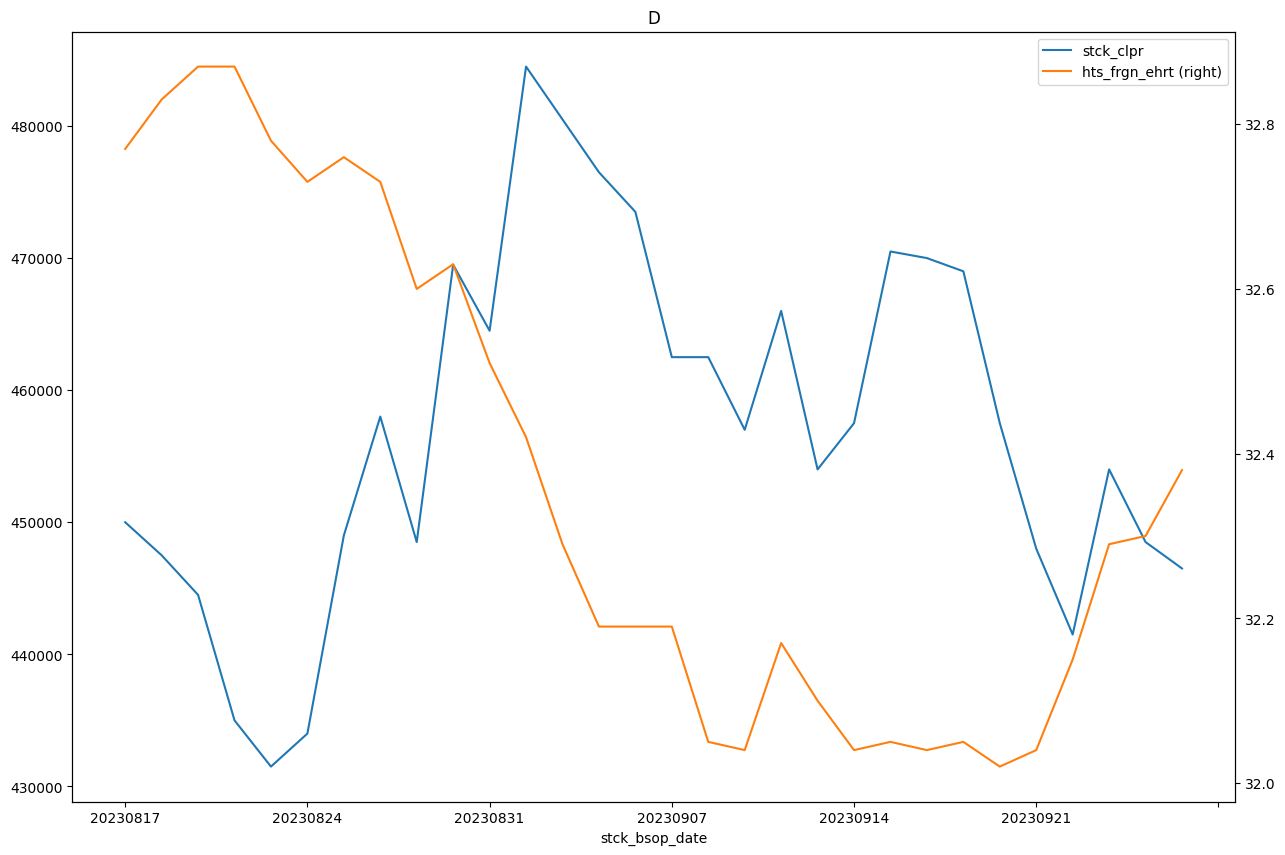

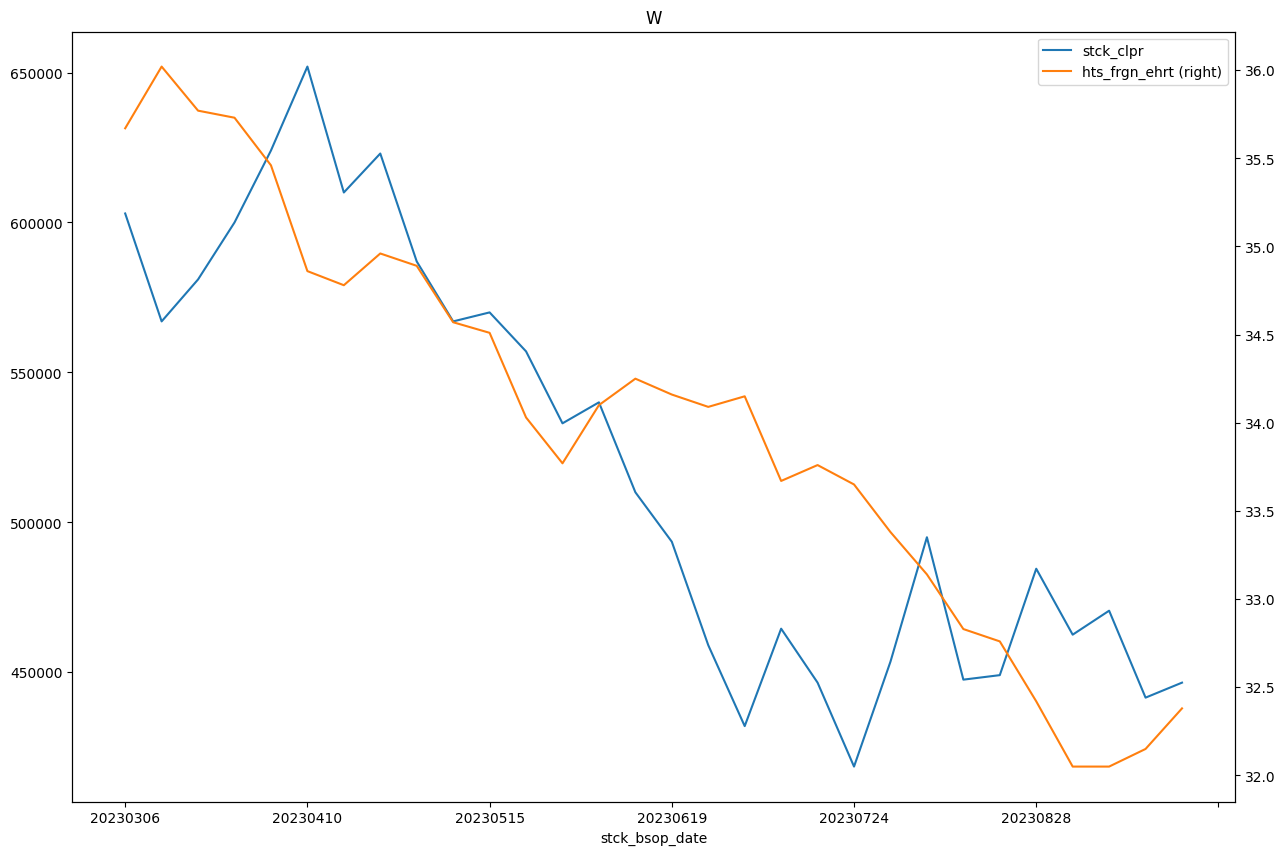

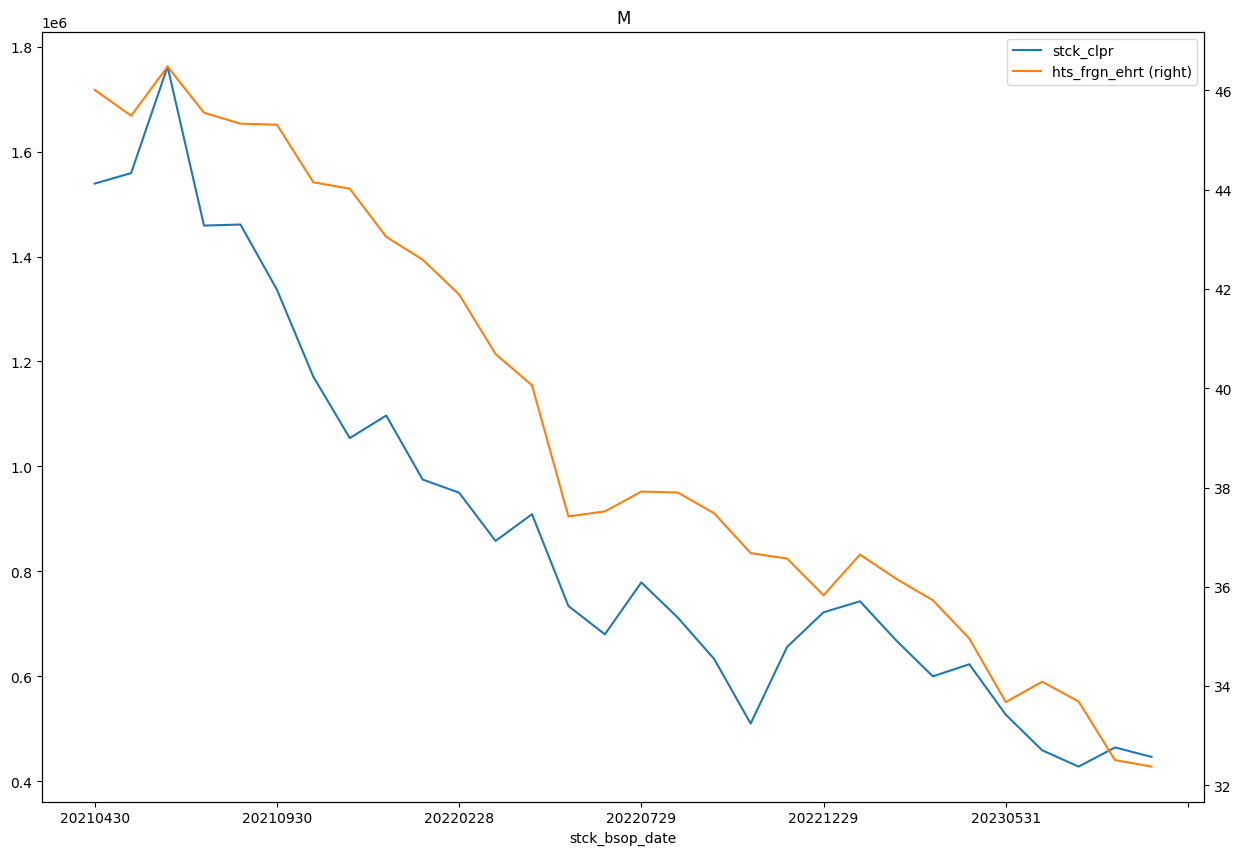

In [148]:
plot_fholdings('051900')